# Optimal Approach to Open a Restaurant in Toronto

# 1. Introduction/Business Problem

A client is looking into starting a restaurant focused on Japanese cuisine. The location would be in Toronto, Canada, but the client would need to know which neighborhood in the city would offer the most benefits to the business operation, and of course, to maximize revenue.

Our objective in this project is to gather information on the different neighborhoods in Toronto, and advise our client with the most strategic location based on demographics of residents, area population, and average income. We will be using the Foursquare API for exploring nearby venues and retrieving demographic data from Toronto’s Open Data Portal.

# 2. Data

### a. Data Sources

* The neighborhoods with their respective postal codes and boroughs were scraped from Wikipedia. 
* Geographical coordinates for each neighborhood were extracted from the file provided to us in last week's assignment. 
* Toronto’s demographic data, such as median household income, total population, and population of different ethnicity for each neighbourhood is retrieved from Toronto’s Open Data Portal. 
* We will also be using the Foursquare API to explore the list of different venues nearby in each neighbourhood.

### b. Data Cleaning

* From the Wikipedia data, we will remove neighborhoods where their boroughs or postal code were labeled as not assigned
* We will remove any neighborhoods that do not have any demographics data from Toronto's Open Data Portal

#### Part 1: Web Scape the Wiki page for Toronto Neighborhoods

In [1]:
import sys
!{sys.executable} -m pip install beautifulsoup4

     |████████████████████████████████| 122kB 5.7MB/s eta 0:00:01


In [2]:
# importing the libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

from sklearn.cluster import KMeans

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         395 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

In [3]:
# Step 1: Sending a HTTP request to a URL
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Step 2: Parse the html content
soup = BeautifulSoup(html_content, "html.parser")
#print(soup.prettify()) # print the parsed data of html

# Step 3: Get the table having the class wikitable sortable
gdp_table = soup.find("table", attrs={"class": "wikitable sortable"})
gdp_table_data = gdp_table.tbody.find_all("tr")  # contains 2 rows

# Step 4: Get headers of table 
t_headers = []
for th in gdp_table.find_all("th"):
    # remove any newlines and extra spaces from left and right
    t_headers.append(th.text.replace('\n', ' ').strip())
    
# Step 5: Get all the rows of table
table_data = []
for tr in gdp_table.tbody.find_all("tr"): # find all tr's from table's tbody
    t_row = {}

    for td, th in zip(tr.find_all("td"), t_headers): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

df = pd.DataFrame(data=table_data[1:], columns = t_headers)
df = df[df['Borough'] != 'Not assigned']
df = df['Neighborhood'].str.split(',').apply(lambda x: pd.Series(x[:])).stack().reset_index(level=1, drop=True).to_frame('Neighborhood').join(df[['Postal Code', 'Borough']], how='left')
df = df[['Postal Code', 'Borough', 'Neighborhood']]

df['Neighborhood'] = df['Neighborhood'].str.split('-', expand=True)[0]
df['Neighborhood'] = df['Neighborhood'].str.strip()

#### Part 2: Retrieve Latitude and Longitude for each Neighborhood

In [4]:
lat_long_df = pd.read_csv('/resources/labs/Geospatial_Coordinates.csv')

result_df = pd.merge(df,
                 lat_long_df, 
                 left_on = 'Postal Code',
                 right_on = 'Postal Code', 
                 how = 'inner')

#### Part 3: Using the Foursquare API, retrieve the number of Asian Restaurants within 1000 meters for each neighborhood

In [21]:
CLIENT_ID = 'JUQFG2FUEPW2LKBVLBV0ETJWGV1VKXNPU04Q5JSBJH5HQACL' # your Foursquare ID
CLIENT_SECRET = 'AGWMTWAZB5J2B0KMLIUWWMMSSH0FKDV0HB52SFGJVGQ25XBH' # your Foursquare Secret
VERSION = '20180604'

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
toronto_venues = getNearbyVenues(  names=result_df['Neighborhood'],
                                   latitudes=result_df['Latitude'],
                                   longitudes=result_df['Longitude']
                                  )
print(toronto_venues.shape)

(5035, 7)


In [24]:
toronto_japanese_restaurants = toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")]

In [25]:
toronto_japanese_restaurants_grouped = toronto_japanese_restaurants.groupby('Neighborhood').count().reset_index()

In [26]:
result_df = pd.merge(result_df,
                 toronto_japanese_restaurants_grouped[['Neighborhood', 'Venue']],
                 left_on = 'Neighborhood', 
                 right_on = 'Neighborhood',
                 how = 'left') 
result_df.rename(columns={'Venue':'# Similar Restaurants Nearby'}, inplace=True)
result_df['# Similar Restaurants Nearby'].replace(np.nan, 0, inplace=True)

In [27]:
result_df['# Similar Restaurants Nearby'] = result_df['# Similar Restaurants Nearby'].astype('int')

#### Part 4: Get the frequency distribution of East Asian population and Median Household Income for each Neighborhood from Toronto's Open Data Portal

In [28]:
from pandas import ExcelWriter
from pandas import ExcelFile


population_df = pd.read_excel('/resources/data/demographics-nhs-indicators-2011.xlsx', sheet_name='Sheet1', skiprows=range(0))
population_df = population_df.iloc[1:]
neighborhood_df = pd.read_excel('/resources/data/wellbeing-toronto-demographics.xlsx', sheet_name='RawData-Ref Period 2011', skiprows=range(1))

population_df = pd.merge(population_df,
                 neighborhood_df[['Neighbourhood', 'Neighbourhood Id']],
                 left_on = 'Hood#', 
                 right_on = 'Neighbourhood Id',
                 how = 'inner') 

population_df = population_df[['Neighbourhood', 'Neighbourhood Id', 'Total Population', '    Chinese', '    Korean', '    Japanese', 
               '  Median household total income $']]
population_df.rename(columns={'    Chinese':'Chinese', '    Korean':'Korean', '    Japanese':'Japanese',  '  Median household total income $':'Median household total income $'}, inplace=True)

population_df['Total Population'] = population_df['Total Population'].astype('int')
population_df['Chinese'] = population_df['Chinese'].astype('int')
population_df['Korean'] = population_df['Korean'].astype('int')
population_df['Japanese'] = population_df['Japanese'].astype('int')
population_df['Median household total income $'] = population_df['Median household total income $'].astype('int')

In [29]:
population_df['Population of East Asian'] = population_df['Chinese'] + population_df['Korean'] + population_df['Japanese']
                                              
population_df['Percentage of East Asian'] = round((population_df['Chinese'] + population_df['Korean'] + population_df['Japanese']) 
                                                  / population_df['Total Population'], 2) 
population_df = population_df[['Neighbourhood', 'Neighbourhood Id', 'Total Population', 'Population of East Asian', 'Percentage of East Asian',
                 'Median household total income $']]
population_df['Neighbourhood'] = population_df['Neighbourhood'].str.split('-', expand=True)[0]

In [30]:
df_all = pd.merge(result_df, 
                  population_df, 
                 left_on = 'Neighborhood', 
                 right_on = 'Neighbourhood',
                 how='left').dropna(how='any', axis=0).reset_index(drop=True).drop(['Borough', 'Postal Code', 'Neighbourhood', 'Neighbourhood Id'], axis=1)

In [31]:
df_all.drop_duplicates(subset=('Neighborhood'), keep='first', inplace=True)

df_all['Total Population'] = df_all['Total Population'].astype('int')
df_all['Population of East Asian'] = df_all['Population of East Asian'].astype('int')

#### Part 5: Exploratory Data Analysis

##### Plot a bar graph to showcase the number of Japanese restaurants in each neighbourhood.

Text(0, 0.5, '# of Nearby Japanese Restaurants')

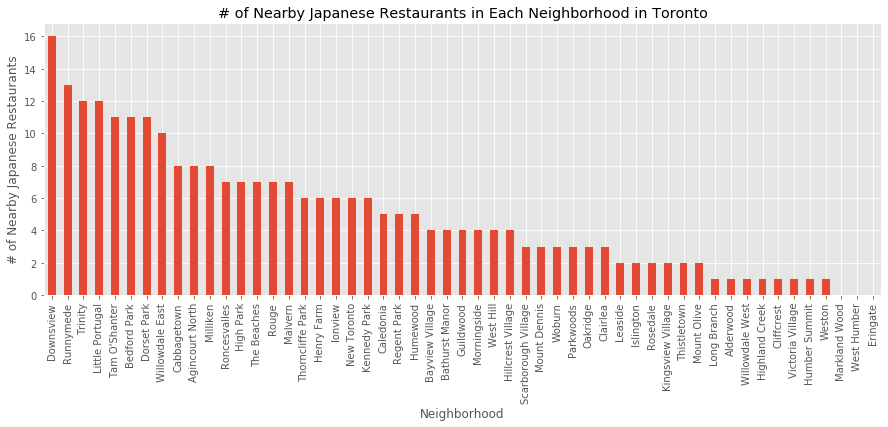

In [32]:
# sort by descending order
df_all.sort_values(by='# Similar Restaurants Nearby', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
df_all.set_index('Neighborhood')['# Similar Restaurants Nearby'].plot(kind='bar', figsize=(15,5))

plt.title('# of Nearby Japanese Restaurants in Each Neighborhood in Toronto')
plt.xlabel('Neighborhood')
plt.ylabel('# of Nearby Japanese Restaurants')

##### Plot a bar graph to display the ratio of East Asian population to total population in each neighbourhood

Text(0, 0.5, 'Percentage of East Asian')

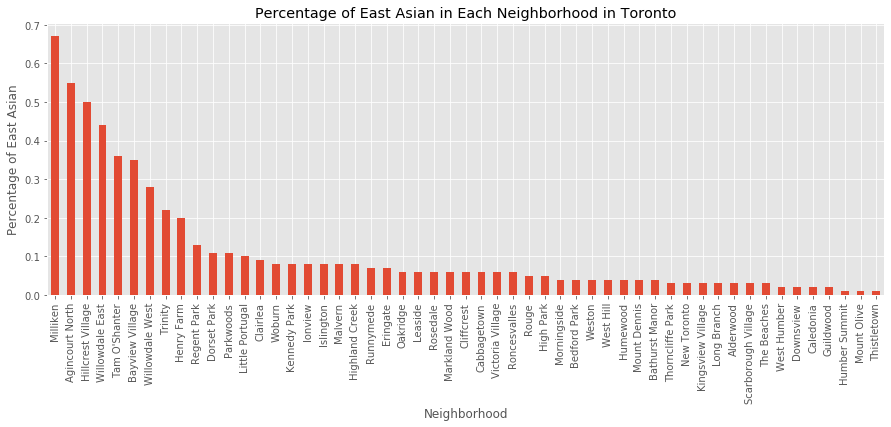

In [33]:
# sort by descending order
df_all.sort_values(by='Percentage of East Asian', ascending=False, inplace=True)

mpl.style.use('ggplot')
df_all.set_index('Neighborhood')['Percentage of East Asian'].plot(kind='bar', figsize=(15,5))

plt.title('Percentage of East Asian in Each Neighborhood in Toronto')
plt.xlabel('Neighborhood')
plt.ylabel('Percentage of East Asian')

##### Plot a bar graph to display the median household total income in each neighborhood

Text(0, 0.5, 'Median household total income $')

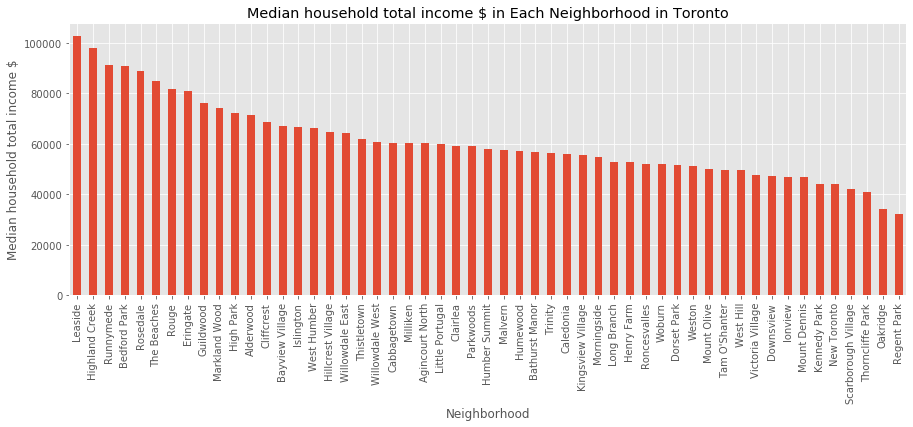

In [34]:
# sort by descending order
df_all.sort_values(by='Median household total income $', ascending=False, inplace=True)

mpl.style.use('ggplot')
df_all.set_index('Neighborhood')['Median household total income $'].plot(kind='bar', figsize=(15,5))

plt.title('Median household total income $ in Each Neighborhood in Toronto')
plt.xlabel('Neighborhood')
plt.ylabel('Median household total income $')

#### Part 6: Clustering the Toronto Neighborhood using K-Means

In [35]:
##Standardize the Quantitative Variables
from sklearn.preprocessing import StandardScaler
X = df_all.values[:,3:]
X = np.nan_to_num(X)
scaler = StandardScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


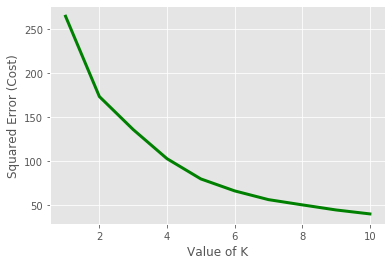

In [36]:
# the point of the elbow is the most optimal value for choosing k 

cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(scaled_data) 
      
    # calculates squared error for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error (Cost)") 
plt.show()

In [37]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(scaled_data)
kmeans.cluster_centers_
kmeans.labels_

array([0, 0, 1, 1, 0, 0, 5, 0, 0, 0, 1, 0, 0, 2, 5, 5, 2, 4, 3, 2, 3, 4,
       4, 1, 3, 5, 3, 5, 3, 3, 1, 3, 3, 3, 3, 3, 3, 5, 1, 3, 5, 2, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [38]:
df_all["Clus_km"] = kmeans.labels_
df_all.head()

,Neighborhood,Latitude,Longitude,# Similar Restaurants Nearby,Total Population,Population of East Asian,Percentage of East Asian,Median household total income $,Clus_km
16,Leaside,43.709060,-79.363452,2,17010,1020,0.06,102666.0,0
6,Highland Creek,43.784535,-79.160497,1,13100,1025,0.08,98087.0,0
38,Runnymede,43.673185,-79.487262,13,9635,670,0.07,91230.0,1
34,Bedford Park,43.733283,-79.419750,11,23185,865,0.04,90934.0,1
53,Rosedale,43.679563,-79.377529,2,20635,1175,0.06,88855.0,0


#### Part 7: Visualize the different clusters on a Map of Toronto

In [39]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [40]:
import matplotlib.cm as cm
import matplotlib.colors as colors

kclusters = 6

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_all['Latitude'], df_all['Longitude'], df_all['Neighborhood'], df_all['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Part 8: Examine Clusters

##### Cluster 0

In [41]:
# Median Household Income: High
# Percentage of East Asian: Low
# Similar Restaurants Nearby: Low

print(df_all.loc[df_all['Clus_km'] == 0].shape)
df_all.loc[df_all['Clus_km'] == 0]

(9, 9)


,Neighborhood,Latitude,Longitude,# Similar Restaurants Nearby,Total Population,Population of East Asian,Percentage of East Asian,Median household total income $,Clus_km
16,Leaside,43.709060,-79.363452,2,17010,1020,0.06,102666.0,0
6,Highland Creek,43.784535,-79.160497,1,13100,1025,0.08,98087.0,0
53,Rosedale,43.679563,-79.377529,2,20635,1175,0.06,88855.0,0
13,The Beaches,43.676357,-79.293031,7,21135,720,0.03,85028.0,0
8,Eringate,43.643515,-79.577201,0,18805,1360,0.07,80894.0,0
10,Guildwood,43.763573,-79.188711,4,9815,245,0.02,76055.0,0
9,Markland Wood,43.643515,-79.577201,0,10435,590,0.06,74376.0,0
54,Alderwood,43.602414,-79.543484,1,11900,355,0.03,71585.0,0
32,Cliffcrest,43.716316,-79.239476,1,15700,960,0.06,68647.0,0


#### Cluster 1

In [42]:
# Median Household Income: Medium
# Percentage of East Asian: Low
# Similar Restaurants Nearby: High

print(df_all.loc[df_all['Clus_km'] == 1].shape)
df_all.loc[df_all['Clus_km'] == 1]

(7, 9)


,Neighborhood,Latitude,Longitude,# Similar Restaurants Nearby,Total Population,Population of East Asian,Percentage of East Asian,Median household total income $,Clus_km
38,Runnymede,43.673185,-79.487262,13,9635,670,0.07,91230.0,1
34,Bedford Park,43.733283,-79.419750,11,23185,865,0.04,90934.0,1
42,High Park,43.661608,-79.464763,7,21750,1090,0.05,72286.0,1
22,Little Portugal,43.647927,-79.419750,12,12055,1160,0.10,59886.0,1
23,Trinity,43.647927,-79.419750,12,16805,3720,0.22,56368.0,1
41,Dorset Park,43.757410,-79.273304,11,24360,2795,0.11,51724.0,1
27,Downsview,43.737473,-79.464763,16,34650,840,0.02,47173.0,1


#### Cluster 2

In [43]:
# Median Household Income: Medium
# Percentage of East Asian: Medium
# Similar Restaurants Nearby: Low

print(df_all.loc[df_all['Clus_km'] == 2].shape)
df_all.loc[df_all['Clus_km'] == 2]

(4, 9)


,Neighborhood,Latitude,Longitude,# Similar Restaurants Nearby,Total Population,Population of East Asian,Percentage of East Asian,Median household total income $,Clus_km
26,Bayview Village,43.786947,-79.385975,4,17675,6135,0.35,67186.0,2
17,Hillcrest Village,43.803762,-79.363452,4,17650,8820,0.50,64522.0,2
43,Willowdale West,43.782736,-79.442259,1,15005,4265,0.28,60537.0,2
47,Tam O'Shanter,43.781638,-79.304302,11,27390,9725,0.36,49720.0,2


#### Cluster 3

In [44]:
# Median Household Income: Low
# Percentage of East Asian: Low
# Similar Restaurants Nearby: Low

print(df_all.loc[df_all['Clus_km'] == 3].shape)
df_all.loc[df_all['Clus_km'] == 3]

(23, 9)


,Neighborhood,Latitude,Longitude,# Similar Restaurants Nearby,Total Population,Population of East Asian,Percentage of East Asian,Median household total income $,Clus_km
52,Thistletown,43.739416,-79.588437,2,10140,115,0.01,62042.0,3
57,Cabbagetown,43.667967,-79.367675,8,12050,695,0.06,60268.0,3
28,Clairlea,43.711112,-79.284577,3,24775,2130,0.09,59224.0,3
31,Humber Summit,43.756303,-79.565963,1,12530,65,0.01,57786.0,3
7,Humewood,43.693781,-79.428191,5,14110,570,0.04,57140.0,3
18,Bathurst Manor,43.754328,-79.442259,4,15435,570,0.04,56563.0,3
14,Caledonia,43.689026,-79.453512,5,9855,155,0.02,56115.0,3
45,Kingsview Village,43.688905,-79.554724,2,21725,665,0.03,55454.0,3
11,Morningside,43.763573,-79.188711,4,17585,755,0.04,54746.0,3
55,Long Branch,43.602414,-79.543484,1,9630,315,0.03,52771.0,3


#### Cluster 4

In [45]:
# Median Household Income: Medium
# Percentage of East Asian: High
# Similar Restaurants Nearby: Medium

print(df_all.loc[df_all['Clus_km'] == 4].shape)
df_all.loc[df_all['Clus_km'] == 4]

(3, 9)


,Neighborhood,Latitude,Longitude,# Similar Restaurants Nearby,Total Population,Population of East Asian,Percentage of East Asian,Median household total income $,Clus_km
36,Willowdale East,43.770120,-79.408493,10,45025,19965,0.44,64362.0,4
48,Milliken,43.815252,-79.284577,8,27160,18135,0.67,60262.0,4
49,Agincourt North,43.815252,-79.284577,8,30280,16765,0.55,60162.0,4


#### Cluster 5

In [46]:
# Median Household Income: Medium
# Percentage of East Asian: Low
# Similar Restaurants Nearby: Medium

print(df_all.loc[df_all['Clus_km'] == 5].shape)
df_all.loc[df_all['Clus_km'] == 5]

(7, 9)


,Neighborhood,Latitude,Longitude,# Similar Restaurants Nearby,Total Population,Population of East Asian,Percentage of East Asian,Median household total income $,Clus_km
4,Rouge,43.806686,-79.194353,7,45905,2205,0.05,81553.0,5
5,Islington,43.650943,-79.554724,2,38070,3050,0.08,66537.0,5
56,West Humber,43.706748,-79.594054,0,34100,850,0.02,66241.0,5
0,Parkwoods,43.753259,-79.329656,3,34620,3910,0.11,59027.0,5
3,Malvern,43.806686,-79.194353,7,45085,3540,0.08,57528.0,5
15,Woburn,43.770992,-79.216917,3,53350,4310,0.08,52018.0,5
51,Mount Olive,43.739416,-79.588437,2,32790,285,0.01,49934.0,5


# 3. Methodology

### a. Why analyze number of Japanese restaurants in each neighborhood

We used the Foursquare API, mainly the Venue Explore endpoint, to retrieve nearby Japanese restaurants within 1000 meters of each neighborhood. The assumption is that if there is a high number of similar restaurants nearby, this can generate a lot of competition for our client's new business, which can go in a negative way if other restaurants already have many loyal customers.

### b. Why analyze the ratio of East Asian population to total population in each neighborhood

We assume there is a positive correlation between the percentage of East Asian population and the demand for Japanese cuisine; therefore, it would benefit our client's business growth if the restaurant were to start up at neighborhood with a relatively densely populated location among East Asians.

### c. Why analyze the median household total income in each neighborhood

Japanese cuisine prices usually tend to be more suitable for middle class income earners and up; therefore, analyzing the median household total income can let us know that if these relative prices could potentially be scaled too expensive for some neighborhoods.

### d. Predictive Modeling : KMeans Clustering

#### Data Preprocessing

In order to segment the Toronto neighborhoods into groups based on their numerical distribution and magnitudes, a good approach for this unsupervised learning task is using KMeans Clustering. 

We must first normalize our quantitative features to a common scale, so that our model can interpret the values equally. For this occasion, we use the StandardScaler to normalize our data.

#### Building a KMeans Clustering Model

One of the important aspects of instantiating a KMeans Clustering model is to specify the most optimal number of clusters for the algorithm to label. Using the Elbow method, we calculated the squared error for a range of 1-10 for our K number of clusters. It was determined that K=6 would deliver the best results for our predictive algorithm.

Next we go ahead and fit our standardized features into the KMeans Cluster model to segment each neighborhood into a cluster.

# 4. Results

Cluster 0 segments the neighborhoods with the highest level of spending power among the clusters and low competition in Japanese Cuisine. However, it also shows that there is a low number in East Asian population, leaving us with an assumption that Japanese cuisine is most likely not in high demand, which could explain why competition was low in the area.
* Median Household Income: High
* Percentage of East Asian: Low
* Similar Restaurants Nearby: Low

Custer 1 shows the group with a medium level spending power. Although, this would be adequate for our business, but both the high number of competitions nearby and a low population of our target customer brings negative value to the growth of our business.
* Median Household Income: Medium
* Percentage of East Asian: Low
* Similar Restaurants Nearby: High

Cluster 2 shows a medium level of spending power and low competition. The locations are fairly populated with East Asians, which does show potential value; however this segment is expressing a greater population of our target customers can further increase the demand for Japanese Cuisine in the area.
* Median Household Income: Medium
* Percentage of East Asian: Medium
* Similar Restaurants Nearby: Low

Cluster 3 describes the group of neighborhood to have a relatively low spending power in each household compared to neighborhoods in other clusters. Although, there is a low number of competition in the area, there also is a low population of the target customers for our client's business.
* Median Household Income: Low
* Percentage of East Asian: Low
* Similar Restaurants Nearby: Low

Cluster 4 shows the neighborhoods with a great number of East Asian residents among total residents, giving our client's business a good chance to attract the local target consumers. The average household income among the group also shows that is adequate for the typical pricing for Japanese cuisine. The fair number of competitions allows our new business to stick out among the others, while also supporting the hypothesis that East Asian cuisine is somewhat popular to locals.
* Median Household Income: Medium
* Percentage of East Asian: High
* Similar Restaurants Nearby: Medium

While Cluster 5 shows that the medium spending power is suitable for typical Japanese cuisine prices and fair number of competitions nearby, it does not seem there will be sufficient amount of the target customers living nearby.
* Median Household Income: Medium
* Percentage of East Asian: Low
* Similar Restaurants Nearby: Medium



# 5. Discussion

Milliken (in Cluster 4) appears to be the most optimal neighborhood to start a Japanese restaurant in Toronto.

In Cluster 2 and Cluster 4, where both have a medium - high ratio of East Asian population, Japanese restaurants have a good chance to stand out to the public due to competition never reaching too high. This detail provides great support in terms of future expansion and franchising the restaurant into different parts of Toronto. The flexibility allows the business to cope with changes in consumer demands in terms of relocation.

# 6. Conclusion

In this study, I have clustered the neighborhoods in Toronto based on their different characteristics, including average annual income per household, ratio of target customers, and the level of competitions nearby. Based on our algorithm, it appears that Cluster 4, especially in Milliken, would bring the most optimal setting to allow our client's business to operate.

The spending power of the residents in this location shows that the typical pricing of Japanese cuisine should not financially impact the local demand.

The high ratio of target customers nearby is a perfect indicator that our Japanese cuisine could already be in high demand and our business would be an attractive addition to the local residents.

The fair number of competitions allows our new business to stick out among the others, while also supporting the hypothesis that East Asian cuisine is somewhat popular to locals.

# 7. Reference

1. My Github for this project:

    https://github.com/jx22553/Coursera_Capstone


2. Wikipedia page on Toronto neighbourhoods for scraping:

    https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

3. Toronto Open Data Portal for demographics data:

    https://open.toronto.ca/dataset/wellbeing-toronto-demographics/

4. Geographical coordinates of Toronto neighborhoods:

    https://cocl.us/Geospatial_data

5. Foursquare Developer API: 

    https://developer.foursquare.com